# Exploratory data analysis and modelling

First, we will look at the distributions of features and relationships between them. 
After that we split the data, fit and optimize models and lastly sum up the results.


In [110]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# import missingno as msno
plt.style.use('ggplot')


In [111]:
# import cleaned dataset
df = pd.read_csv('data/dataset_cleaned.csv')
# drop index column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [16]:
# if value is 0 or 'missing', replace with NaN
df = df.replace(0, np.nan)
df = df.replace('missing', np.nan)

# drop columns with more than 25% missing values
df.dropna(thresh=len(df)*0.25, axis=1, inplace=True)


In [4]:
# see the statictical summary of the numerical columns
df.describe().round(0)


,Price,SurfaceArea,YearBuilt,TotalFloorsInBuilding,YearRenovated,TotalRooms,LandArea
count,1985.0,1398.0,1896.0,579.0,742.0,736.0,516.0
mean,247817.0,144.0,1966.0,4.0,2010.0,5.0,487.0
std,178323.0,110.0,58.0,3.0,14.0,2.0,256.0
min,1.0,1.0,1500.0,1.0,1900.0,1.0,1.0
25%,125000.0,71.0,1953.0,2.0,2005.0,3.0,296.0
50%,196000.0,110.0,1979.0,3.0,2013.0,5.0,464.0
75%,320000.0,182.0,2006.0,5.0,2019.0,6.0,686.0
max,999999.0,889.0,2024.0,21.0,2022.0,10.0,999.0


In [5]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985 entries, 0 to 1984
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Price                  1985 non-null   int64  
 1   SurfaceArea            1398 non-null   float64
 2   ApartmentType          792 non-null    object 
 3   YearBuilt              1896 non-null   float64
 4   ApartmentSetting       523 non-null    object 
 5   TotalFloorsInBuilding  579 non-null    float64
 6   YearRenovated          742 non-null    float64
 7   BalconyTerraceAtrium   705 non-null    object 
 8   Furniture              706 non-null    object 
 9   NetArea                1194 non-null   object 
 10  EnergyClass            924 non-null    object 
 11  ListingType            1985 non-null   object 
 12  TotalRooms             736 non-null    float64
 13  HouseMaterial          548 non-null    object 
 14  HouseType              1061 non-null   object 
 15  Land

Price
SurfaceArea
ApartmentType


<AxesSubplot: xlabel='ApartmentType', ylabel='Count'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, '2-bedroom'),
  Text(1, 0, 'missing'),
  Text(2, 0, '3-bedroom'),
  Text(3, 0, '1,5-bedroom'),
  Text(4, 0, '4-bedroom'),
  Text(5, 0, '2,5-bedroom'),
  Text(6, 0, '6 in večbedroom'),
  Text(7, 0, '1-bedroom'),
  Text(8, 0, '3,5-bedroom'),
  Text(9, 0, 'Studio'),
  Text(10, 0, 'Drugo'),
  Text(11, 0, '5-bedroom'),
  Text(12, 0, '4,5-bedroom'),
  Text(13, 0, 'Apartma')])

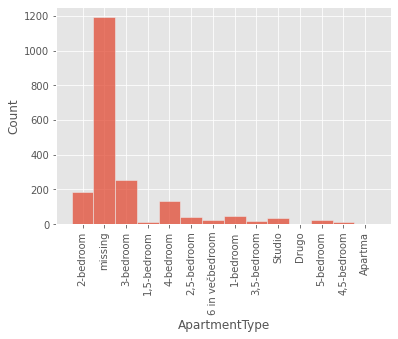

YearBuilt
ApartmentSetting


<AxesSubplot: xlabel='ApartmentSetting', ylabel='Count'>

([0, 1, 2],
 [Text(0, 0, 'V večstanovanjski stavbi'),
  Text(1, 0, 'missing'),
  Text(2, 0, 'V hiši')])

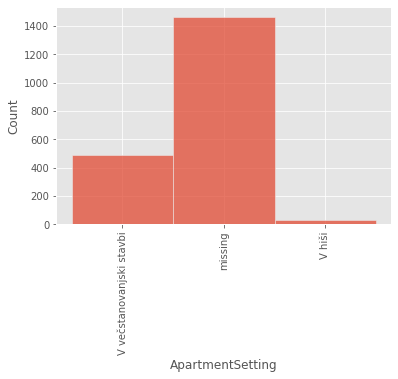

FloorNumber


<AxesSubplot: xlabel='FloorNumber', ylabel='Count'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, '2.'),
  Text(1, 0, '5.'),
  Text(2, 0, 'missing'),
  Text(3, 0, '3.'),
  Text(4, 0, '4.'),
  Text(5, 0, '1.'),
  Text(6, 0, '7.'),
  Text(7, 0, '6.'),
  Text(8, 0, '8.'),
  Text(9, 0, '12.'),
  Text(10, 0, '14.'),
  Text(11, 0, '10.'),
  Text(12, 0, '11.'),
  Text(13, 0, '9.'),
  Text(14, 0, '13.')])

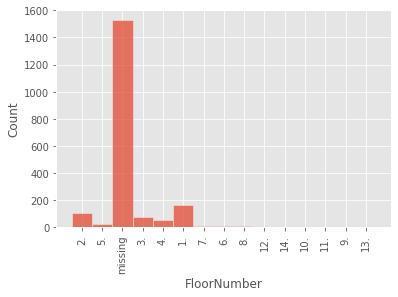

TotalFloorsInBuilding
YearRenovated
BalconyTerraceAtrium


<AxesSubplot: xlabel='BalconyTerraceAtrium', ylabel='Count'>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, 'Balkon'),
  Text(1, 0, 'missing'),
  Text(2, 0, 'Loža'),
  Text(3, 0, 'Terasa'),
  Text(4, 0, 'Atrij'),
  Text(5, 0, 'Balkon, Zaprt balkon'),
  Text(6, 0, 'Balkon, Terasa, Atrij'),
  Text(7, 0, 'Terasa, Loža, Atrij'),
  Text(8, 0, 'Balkon, Atrij, Terasa'),
  Text(9, 0, 'Balkon, Atrij'),
  Text(10, 0, 'Balkon, Terasa'),
  Text(11, 0, 'Zaprt balkon'),
  Text(12, 0, 'Atrij, Terasa'),
  Text(13, 0, 'Terasa, Atrij'),
  Text(14, 0, 'Balkon, Loža'),
  Text(15, 0, 'Balkon, Terasa, Loža'),
  Text(16, 0, 'Loža, Atrij'),
  Text(17, 0, 'Balkon, Zaprt balkon, Terasa, Loža, Atrij'),
  Text(18, 0, 'Balkon, Terasa, Loža, Atrij'),
  Text(19, 0, 'Zaprt balkon, Terasa'),
  Text(20, 0, 'Balkon, Zaprt balkon, Terasa'),
  Text(21, 0, 'Balkon, Zaprt balkon, Terasa, Loža'),
  Text(22, 0, 'Terasa, Loža'),
  Text(23, 0, 'Balkon, Zaprt balkon, Terasa, Atrij'),

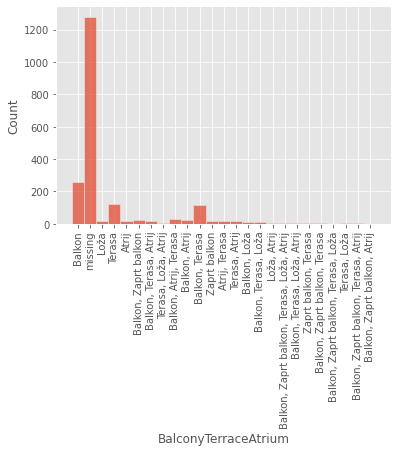

OutdoorFurniture
Furniture


<AxesSubplot: xlabel='Furniture', ylabel='Count'>

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'missing'),
  Text(1, 0, 'Popolnoma opremljeno'),
  Text(2, 0, 'Delno opremljeno'),
  Text(3, 0, 'Neopremljeno'),
  Text(4, 0, 'Potrebno obnove'),
  Text(5, 0, 'Nedokončana gradnja')])

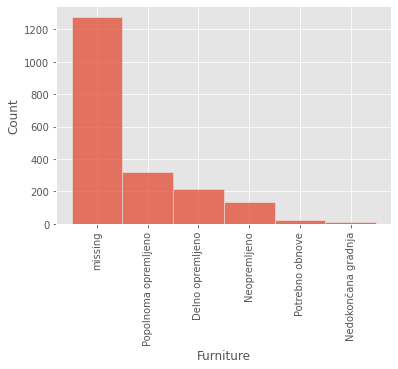

ParkingSpots
NetArea
EnergyClass
ListingType


<AxesSubplot: xlabel='ListingType', ylabel='Count'>

([0, 1], [Text(0, 0, 'flat'), Text(1, 0, 'house')])

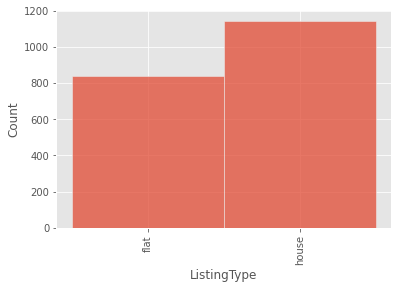

TotalRooms
TotalFloors


<AxesSubplot: xlabel='TotalFloors', ylabel='Count'>

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'missing'),
  Text(1, 0, 'Dvonadstropna'),
  Text(2, 0, 'Enonadstropna'),
  Text(3, 0, 'Večnadstropna'),
  Text(4, 0, 'Pritlična'),
  Text(5, 0, 'Visokopritlična')])

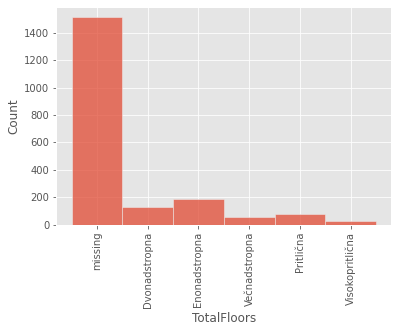

HouseMaterial


<AxesSubplot: xlabel='HouseMaterial', ylabel='Count'>

([0, 1, 2, 3],
 [Text(0, 0, 'missing'),
  Text(1, 0, 'Zidana hiša (beton, opeka)'),
  Text(2, 0, 'Lesena hiša'),
  Text(3, 0, 'Kamnita hiša')])

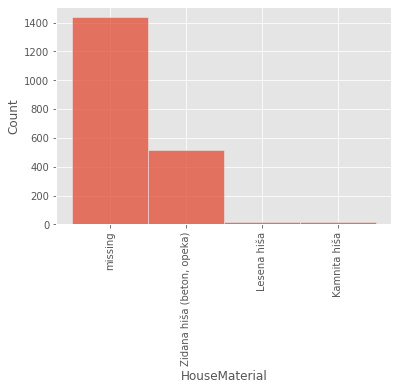

HouseType


<AxesSubplot: xlabel='HouseType', ylabel='Count'>

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'missing'),
  Text(1, 0, 'Dvojček'),
  Text(2, 0, 'Samostojna'),
  Text(3, 0, 'Dvostanovanjska'),
  Text(4, 0, 'Vrstna'),
  Text(5, 0, 'Kmetija'),
  Text(6, 0, 'Stanovanjsko-poslovna'),
  Text(7, 0, 'Ostalo'),
  Text(8, 0, 'Atrijska')])

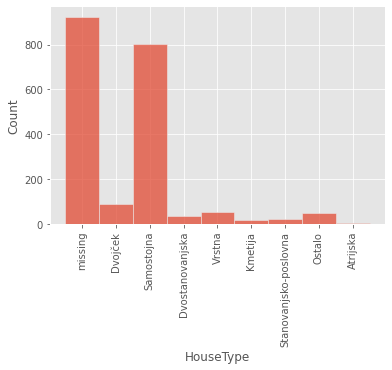

LandArea
Region


<AxesSubplot: xlabel='Region', ylabel='Count'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Gorenjska'),
  Text(1, 0, 'Podravska'),
  Text(2, 0, 'Savinjska'),
  Text(3, 0, 'Osrednjeslovenska'),
  Text(4, 0, 'Goriška'),
  Text(5, 0, 'Obalno-kraška'),
  Text(6, 0, 'Koroška'),
  Text(7, 0, 'Pomurska'),
  Text(8, 0, 'Zasavska'),
  Text(9, 0, 'Jugovzhodna Slovenija'),
  Text(10, 0, 'Posavska'),
  Text(11, 0, 'Primorsko-notranjska')])

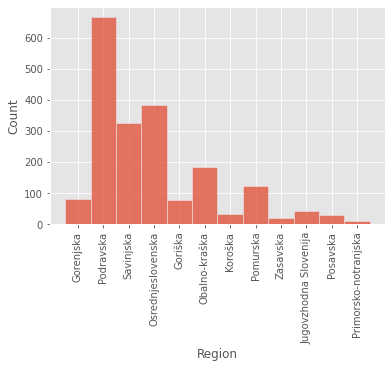

District
Neighborhood


<Figure size 432x288 with 0 Axes>

In [70]:
for label in df.columns:
  print(label)
  if(df[label].dtype == 'object') and (len(list(df[label].unique())) <= 25):
    sns.histplot(data=df, x=label)
    # set labels
    plt.xticks(rotation = 90)
    #plt.tight_layout()
    # save img
    plt.rcParams.update({
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"})

    plt.savefig('./img/histogram_' + label + '.png', dpi=150, bbox_inches='tight')
    plt.show()
    plt.clf()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


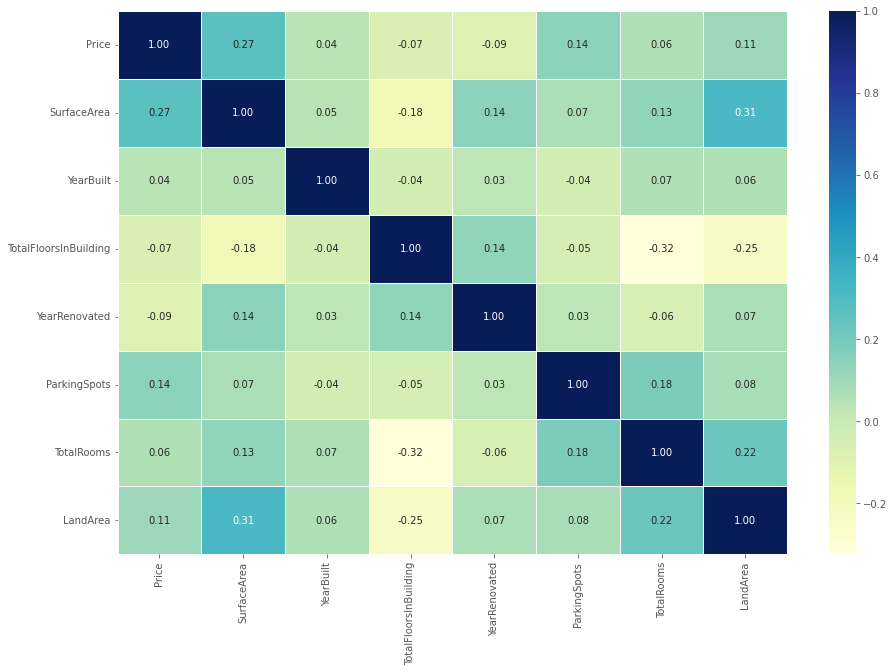

In [112]:
# create a correlation matrix
corr_matrix = df.corr()

# plot the correlation matrix
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_matrix,
                  annot=True,
                  linewidths=0.5,
                  fmt=".2f",
                  cmap="YlGnBu");
                    

In [106]:
# average price per m2
# df['PricePerM2'] = df['Price'] / df['SurfaceArea'].round(0)
# df['PricePerM2'].describe().round(0)



<AxesSubplot: xlabel='Price'>

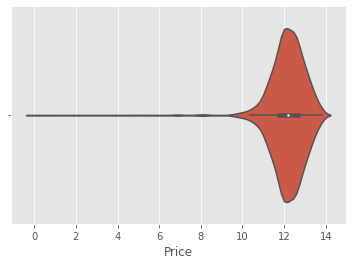

In [130]:
# plot price distribution
sns.violinplot(data=df, x='Price')



In [5]:
# price mean and median
df['Price'].mean().round(0)

247817.0

<AxesSubplot: xlabel='SurfaceArea', ylabel='Price'>

<AxesSubplot: xlabel='SurfaceArea', ylabel='Price'>

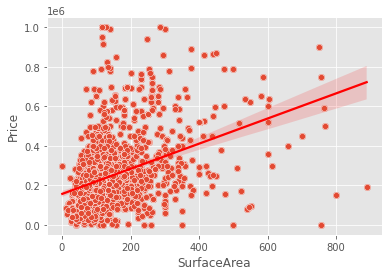

In [75]:
# scaterplot price and surface area with a regression line
sns.regplot(data=df, x='SurfaceArea', y='Price', line_kws={'color': 'red'})
sns.scatterplot(data=df, x='SurfaceArea', y='Price')

<AxesSubplot: xlabel='SurfaceArea', ylabel='Price'>

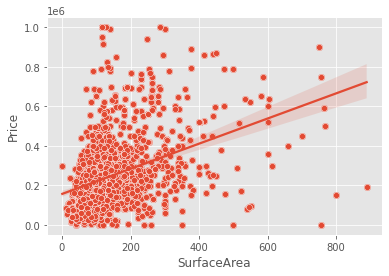

In [13]:
# regression and scatteršplot for price and surface area
sns.regplot(data=df, x='SurfaceArea', y='Price')
sns.scatterplot(data=df, x='SurfaceArea', y='Price')
# set labels


In [143]:
# delete dataset 
del df

# read in dataset
df = pd.read_csv('data/dataset_cleaned.csv')
# drop index column
df.drop('Unnamed: 0', axis=1, inplace=True)

# Encode data, split dataframe and fit models

In [144]:
# import the models, metrics and cross validation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
np.set_printoptions(precision=4)
import time
import shap

In [145]:
df.describe().round(0)

,Price,SurfaceArea,YearBuilt,TotalFloorsInBuilding,YearRenovated,ParkingSpots,TotalRooms,LandArea
count,1985.0,1985.0,1985.0,1985.0,1985.0,1985.0,1985.0,1985.0
mean,247817.0,101.0,1878.0,1.0,751.0,1.0,2.0,127.0
std,178323.0,113.0,411.0,2.0,973.0,1.0,3.0,250.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,125000.0,0.0,1939.0,0.0,0.0,0.0,0.0,0.0
50%,196000.0,77.0,1978.0,0.0,0.0,0.0,0.0,0.0
75%,320000.0,144.0,2005.0,2.0,2008.0,0.0,4.0,77.0
max,999999.0,889.0,2024.0,21.0,2022.0,7.0,10.0,999.0


In [147]:
# drop columns with more than 25% missing values
df.dropna(thresh=len(df)*0.25, axis=1, inplace=True)

<AxesSubplot: xlabel='YearBuilt', ylabel='Count'>

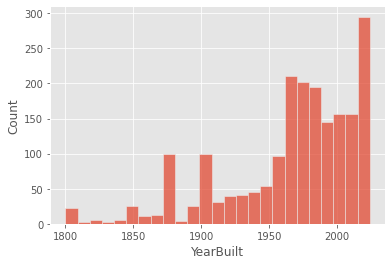

In [148]:
# if yearbuilt is below 1800, replace with the mean
for i in df['YearBuilt']: 
    if i < 1800:
        df['YearBuilt'].replace(i, df['YearBuilt'].mean(), inplace=True) 
#dist of yearbuilt
sns.histplot(data=df, x='YearBuilt')

<AxesSubplot: xlabel='Price', ylabel='Count'>

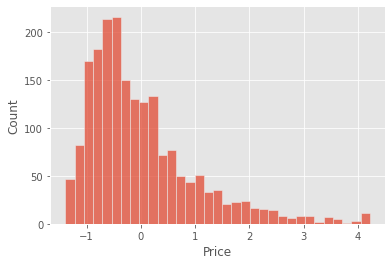

In [149]:
# transform price by substracting mean and dividing by standard deviation
df['Price'] = (df['Price'] - df['Price'].mean()) / df['Price'].std()
sns.histplot(data=df, x='Price')

In [150]:
train, test = train_test_split(df, test_size=0.2, random_state = 2)

In [151]:
# impute categorical columns with LabelEncoder
def ImputeCategoricalFeatures(df):
    # Find the columns of object type along with their column index
    object_cols = list(df.select_dtypes(exclude=[np.int64,np.float64]).columns)
    object_cols_ind = []
    for col in object_cols:
        object_cols_ind.append(df.columns.get_loc(col))

    # Encode the categorical columns with numbers
    label_enc = LabelEncoder()
    encoders = {}
    
    
    for i in object_cols_ind:
        df.iloc[:,i] = label_enc.fit_transform(df.iloc[:,i])
        encoders[i] = label_enc
    return df

In [152]:
train_imp = ImputeCategoricalFeatures(train)
test_imp = ImputeCategoricalFeatures(test)

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


In [153]:
# split the data into X and y
X_train = train_imp.drop('Price', axis =1)
y_train = np.ravel(np.array(train_imp[['Price']]))
X_test = test_imp.drop('Price', axis =1)
y_test = np.ravel(np.array(test_imp[['Price']]))

In [154]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1588, 22)
(1588,)
(397, 22)
(397,)


In [155]:
# define the valuation metrics
# mae
def mse(y_test, y_preds):
    return mean_squared_error(y_test, y_preds)

# rmse
def rmse(y_test, y_preds):
    return np.sqrt(mean_squared_error(y_test, y_preds))

# mape
def mape(y_test, y_preds):
    return np.mean(np.abs((y_test - y_preds) / y_test)) * 100

# R2
def r2(y_test, y_preds):
    return r2_score(y_test, y_preds)




In [156]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [157]:
# make a dict with all metrics
metrics = {'mse': mse,
            'rmse': rmse,
            'mape': mape,
            'r2': r2}
            

In [158]:
models = {'LinearRegression': LinearRegression(),
            'DecisionTreeRegressor': DecisionTreeRegressor(),
            'RandomForestRegressor': RandomForestRegressor(),
            }
            

# Linear regression


In [159]:
%%time
ln_model = LinearRegression()
kf = KFold(n_splits=5)
y_pred_rf = cross_val_score(ln_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_rf.mean())
print(y_pred_rf)

0.1848553844029221
[0.1819 0.2148 0.1692 0.1598 0.1986]
CPU times: total: 156 ms
Wall time: 3.22 s


In [160]:
# evaluate the model for train and test for each metric and return a df
def evaluate_model(model, X_train, y_train, X_test, y_test, metrics):
    # create a dict for the results
    results = {}
    results_test = {}
    # train the model
    model.fit(X_train, y_train)
    # predict the model
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    # evaluate the model for each metric
    results['model'] = model.__class__.__name__ + ' train' 
    for name, metric in metrics.items():
        results[name] = metric(y_train, y_train_pred) 

    results_test['model'] = model.__class__.__name__ + ' test'
    for name, metric in metrics.items():
        results_test[name] = metric(y_test, y_test_pred)
    
    pd_results_test = pd.DataFrame(results_test, index=[0])
    pd_results = pd.DataFrame(results, index=[0])

    results = pd_results.append(pd_results_test, ignore_index=True)
    return results


In [161]:
evaluate_model(ln_model, X_train, y_train, X_test, y_test, metrics).round(2)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,model,mse,rmse,mape,r2
0,LinearRegression train,0.76,0.87,242.79,0.21
1,LinearRegression test,0.94,0.97,218.08,0.18


In [162]:
# for model in model evaluate the model
results = pd.DataFrame()
for name, model in models.items():
    results = results.append(evaluate_model(model, X_train, y_train, X_test, y_test, metrics), ignore_index=True)
results.round(2)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,model,mse,rmse,mape,r2
0,LinearRegression train,0.76,0.87,242.79,0.21
1,LinearRegression test,0.94,0.97,218.08,0.18
2,DecisionTreeRegressor train,0.00,0.01,0.44,1.00
3,DecisionTreeRegressor test,1.21,1.10,438.48,-0.06
4,RandomForestRegressor train,0.07,0.26,105.22,0.93
5,RandomForestRegressor test,0.71,0.84,228.82,0.38


In [163]:
# optimise each model with RandomizedSearchCV
# define the parameters for each model
params = {'LinearRegression': {},
            'DecisionTreeRegressor': {'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                                    'min_samples_split': [2, 5, 10],
                                    'min_samples_leaf': [1, 2, 4],
                                    'max_features': ['auto', 'sqrt', 'log2']},
            'RandomForestRegressor': {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                                    'max_features': ['auto', 'sqrt'],
                                    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                                    'min_samples_split': [2, 5, 10],
                                    'min_samples_leaf': [1, 2, 4],
                                    'bootstrap': [True, False]},                                   
            'BaggingRegressor': {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                                'max_samples': [1, 2, 3, 4, 5], 
                                'max_features': [1, 2, 3, 4, 5],
                                'bootstrap': [True, False],
                                'bootstrap_features': [True, False]}}


Decision tree regression

In [164]:
%%time
dt_model = DecisionTreeRegressor(random_state=1)

kf = KFold(n_splits=5)
y_pred_rf = cross_val_score(dt_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_rf.mean())
print(y_pred_rf)

0.1052072897162141
[ 0.1472  0.1621 -0.0767  0.018   0.2755]
CPU times: total: 46.9 ms
Wall time: 2.13 s


In [165]:
%%time
dt_model.fit(X_train, y_train)
y_train_pred_rf = dt_model.predict(X_train)

print('train R2: ' + str(r2(y_train, y_train_pred_rf)))

y_test_pred_rf = dt_model.predict(X_test)
print('test R2: ' + str(r2(y_test, y_test_pred_rf)))
dt_model.get_params()

train R2: 0.999857673252707
test R2: -0.09672713214574125
CPU times: total: 31.2 ms
Wall time: 33.1 ms


{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

<BarContainer object of 22 artists>

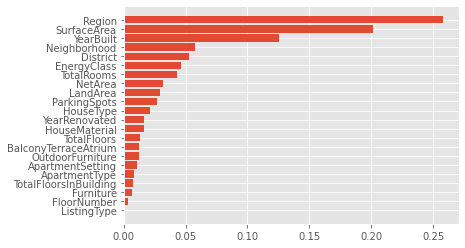

In [166]:
sorted_idx = dt_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), dt_model.feature_importances_[sorted_idx])

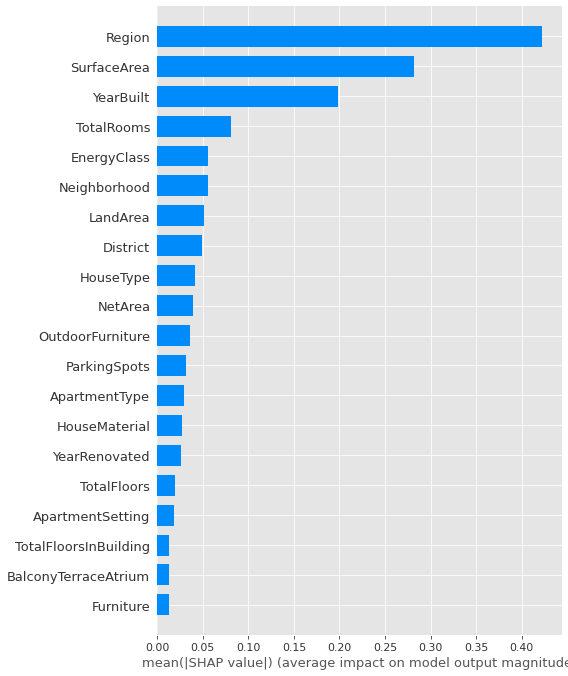

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

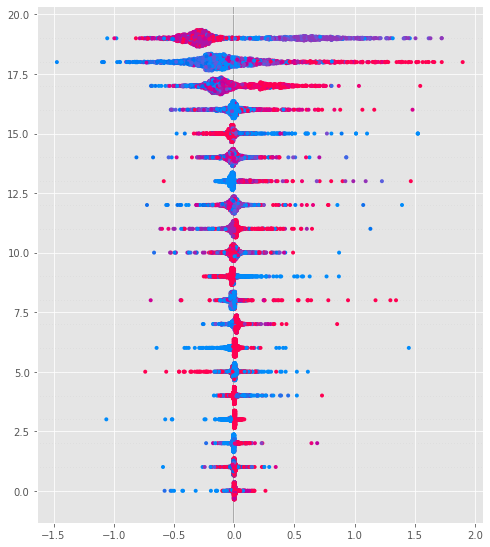

In [167]:
explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [168]:
# Create the parameter grid based on the results of random for decision tree
param_grid = {
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 1.0,'sqrt', 'log2']
}

# Create a base model
dt = DecisionTreeRegressor(random_state = 1)

# Instantiate the grid search model
grid_search_dt = GridSearchCV(estimator = dt, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [169]:
# Fit the grid search to the data

grid_search_dt.fit(X_train,y_train)

Fitting 3 folds for each of 297 candidates, totalling 891 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       110],
                         'max_features': [1.0, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, verbose=2)

In [170]:
dt_best = grid_search_dt.best_estimator_.fit(X_train, y_train)
y_pred_dt_best = dt_best.predict(X_train)

y_train_pred_dt_best = dt_best.predict(X_train)
print('train R2: ' + str(r2(y_train, y_train_pred_dt_best)))


y_test_pred_dt_best = dt_best.predict(X_test)
print('test R2: ' + str(r2(y_test, y_test_pred_dt_best)))

train R2: 0.7930853441345634
test R2: 0.013272733082245192


<BarContainer object of 22 artists>

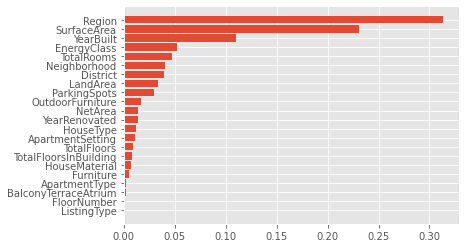

In [171]:
sorted_idx = dt_best.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), dt_best.feature_importances_[sorted_idx])

In [172]:
dt_best = grid_search_dt.best_params_
dt_best


{'max_depth': 10,
 'max_features': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

Random Forest regressor

In [173]:
%%time
rf_model = RandomForestRegressor(#n_estimators=300,
                                      #max_depth=10,
                                      #min_samples_split=5,
                                      #min_samples_leaf=5,
                                      #max_features=None,
                                      random_state=1,
                                      #oob_score=True
                                     )
kf = KFold(n_splits=5)
y_pred_rf = cross_val_score(rf_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_rf.mean())
print(y_pred_rf)

0.48610373809460017
[0.5364 0.4134 0.4376 0.5084 0.5346]
CPU times: total: 31.2 ms
Wall time: 1.55 s


In [174]:
%%time
rf_model.fit(X_train, y_train)
y_train_pred_rf = rf_model.predict(X_train)

print('train R2: ' + str(r2(y_train, y_train_pred_rf)))

y_test_pred_rf = rf_model.predict(X_test)
print('test R2: ' + str(r2(y_test, y_test_pred_rf)))
rf_model.get_params()

train R2: 0.930520147705571
test R2: 0.3868579847954946
CPU times: total: 1.78 s
Wall time: 1.88 s


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

<BarContainer object of 22 artists>

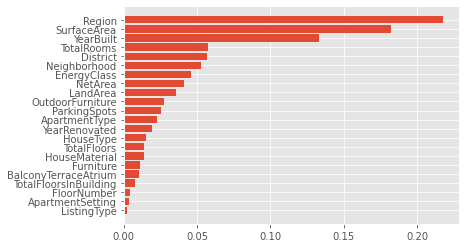

In [175]:
sorted_idx = rf_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), rf_model.feature_importances_[sorted_idx])

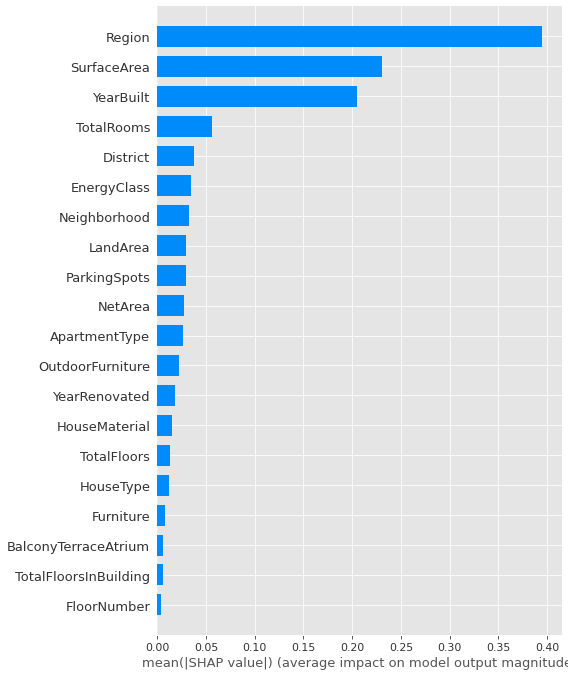

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

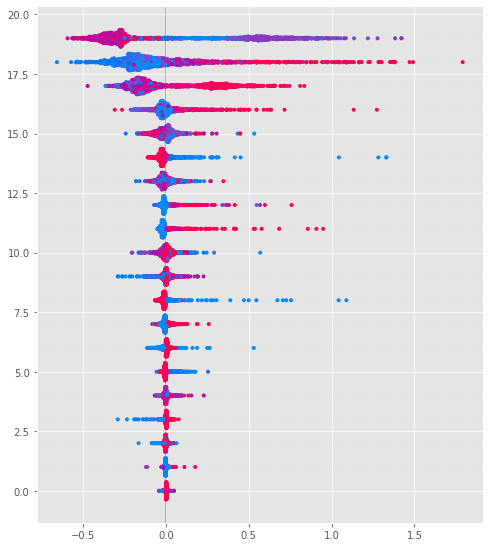

In [176]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [3,4,5,7,9],
    'max_features': [3,4,5,7,10],
    #'max_features': [int(x) for x in np.linspace(start = 3, stop = 10, num = 4)],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12], 
    'n_estimators': [100,200,300,500,700,1000]
}

# Create a base model
rf = RandomForestRegressor(random_state = 1)

# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [ ]:
# Fit the grid search to the data
grid_search_rf.fit(X_train,y_train)

Fitting 3 folds for each of 1350 candidates, totalling 4050 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [3, 4, 5, 7, 9],
                         'max_features': [3, 4, 5, 7, 10],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 500, 700, 1000]},
             return_train_score=True, verbose=2)

In [ ]:
rf_best = grid_search_rf.best_estimator_.fit(X_train, y_train)
y_pred_rf_best = rf_best.predict(X_train)

y_train_pred_rf_best = rf_best.predict(X_train)
print('train R2: ' + str(r2(y_train, y_train_pred_rf_best)))

y_test_pred_rf_best = rf_best.predict(X_test)
print('test R2: ' + str(r2(y_test, y_test_pred_rf_best)))

train R2: 0.7405039220553611
test R2: 0.39808783238068524


In [ ]:
rf_best = grid_search_rf.best_params_
rf_best


{'bootstrap': True,
 'max_depth': 9,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 700}

In [ ]:
rf_best = grid_search_rf.best_estimator_.fit(X_train, y_train)
y_pred_rf_best = rf_best.predict(X_train)

y_train_pred_rf_best = rf_best.predict(X_train)
print('train R2: ' + str(r2(y_train, y_train_pred_rf_best)))

y_test_pred_rf_best = rf_best.predict(X_test)
print('test R2: ' + str(r2(y_test, y_test_pred_rf_best)))

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

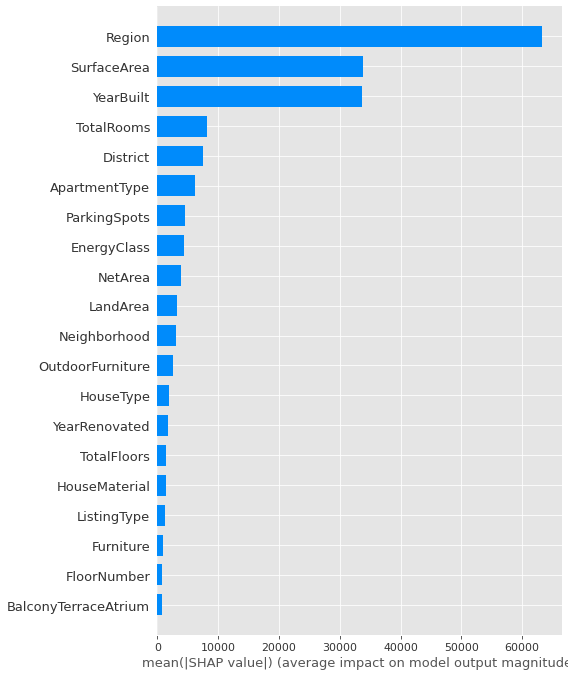

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

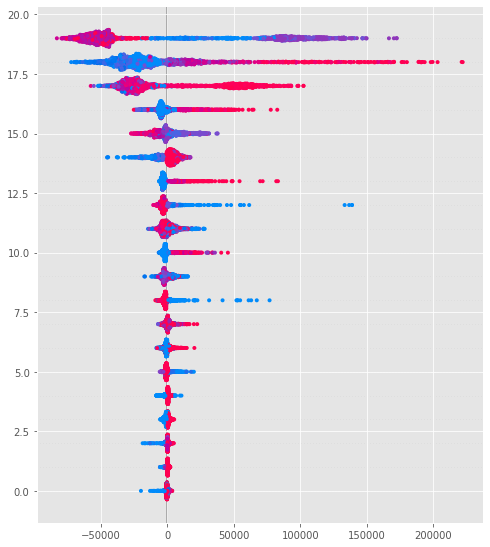

In [ ]:
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train, plot_type="dot")

NameError: name 'rf_model' is not defined

In [25]:
from xgboost import XGBRegressor


In [26]:
%%time
xgboost_model = XGBRegressor(#learning_rate=0.01,
                         #n_estimators=1000,
                         #max_depth=4, min_child_weight=1,
                         #gamma=0.6, subsample=0.7,
                         #colsample_bytree=0.2,
                         #nthread=-1,
                         #scale_pos_weight=1, seed=27,
                         #reg_alpha=0.001
                       )

kf = KFold(n_splits=5)
y_pred_xgboost = cross_val_score(xgboost_model, X_train, y_train, cv=kf, n_jobs=-1)
print(y_pred_xgboost.mean())
print(y_pred_xgboost)
                        
# https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde
                            


0.46557506329952714
[0.5002 0.4862 0.391  0.4907 0.4599]
CPU times: total: 31.2 ms
Wall time: 2.4 s


In [27]:
%time
xgboost_model.fit(X_train, y_train)

y_train_pred_xgboost = xgboost_model.predict(X_train)
print('train R2: ' + str(r2(y_train, y_train_pred_xgboost)))

y_test_pred_xgboost = xgboost_model.predict(X_test)
print('test R2: ' + str(r2(y_test, y_test_pred_xgboost)))

CPU times: total: 0 ns
Wall time: 0 ns


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

train R2: 0.9938890755440722
test R2: 0.3069976170411639


In [28]:
from sklearn.model_selection import GridSearchCV


<BarContainer object of 22 artists>

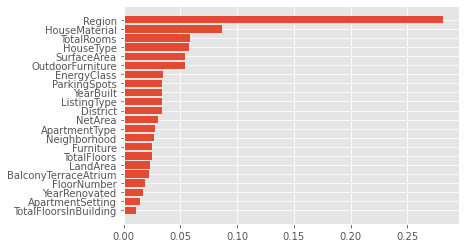

In [29]:

sorted_idx = xgboost_model.feature_importances_.argsort()
plt.barh(list(X_test.columns[sorted_idx]), xgboost_model.feature_importances_[sorted_idx])

In [71]:
                            
param_grid = {
    'learning_rate': [0.005, 0.010, 0.02, 0.05],
    #'min_child_weight':[1,2,3],
    #"gamma"        : [ 0.1, 0.2 , 0.3],
    "colsample_bytree" : [ 0.2, 0.3],
    'max_depth': [2,3,4, 5,],
    'max_features': [4,5],
    'n_estimators': [300, 500, 700, 1000]
}

# Create a base model
xgboost_model = XGBRegressor(random_state = 1)

# Instantiate the grid search model
grid_search_xgboost = GridSearchCV(estimator = xgboost_model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [72]:
# Fit the grid search to the data
grid_search_xgboost.fit(X_train,y_train)

Fitting 3 folds for each of 256 candidates, totalling 768 fits
[09:43:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=1,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.2, 0.3],
                         'learning_rate': [0.005, 0.01, 0.02, 0.05],
                         'max_depth': [2, 3, 4, 5], 'max_features': [4, 5],
                         'n_estimators': [300, 500, 700, 1000]},
             return_train_score=True, verbose=2)

In [73]:
xgboost_best_par = grid_search_xgboost.best_params_
xgboost_best_par

{'colsample_bytree': 0.3,
 'learning_rate': 0.05,
 'max_depth': 5,
 'max_features': 4,
 'n_estimators': 300}

In [74]:
#Evaluation of the best model
xgboost_best = grid_search_xgboost.best_estimator_.fit(X_train, y_train)
y_pred_xgboost_best = xgboost_best.predict(X_train)

y_train_pred_xgboost_best = xgboost_best.predict(X_train)
print('train R2: ' + str(r2(y_train, y_train_pred_xgboost_best)))

y_test_pred_xgboost_best = xgboost_best.predict(X_test)
print('test R2: ' + str(r2(y_test, y_test_pred_xgboost_best)))

[09:43:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


train R2: 0.8888542407188839
test R2: 0.31504423974077655


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


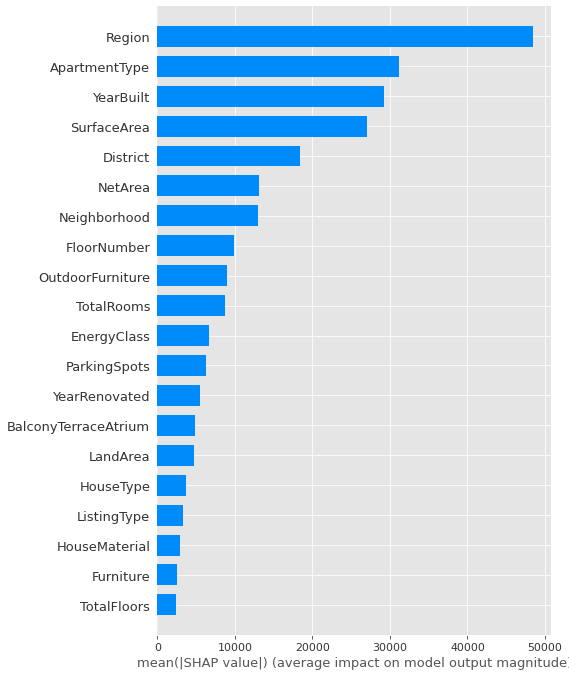

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

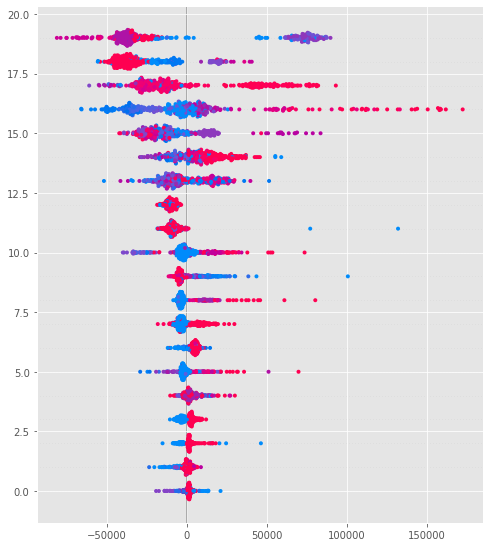

In [75]:
explainer = shap.TreeExplainer(xgboost_best)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test,  plot_type="dot")

In [ ]:
import	shap

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Make a df of scores for for every metric for models: linear regression, decision tree, random forest, xgboost
for metric in metrics: 
    scores = pd.DataFrame({'model': ['linear regression', 'decision tree', 'random forest', 'xgboost'],
                           'train': [r2(y_train, y_train_pred_lr), r2(y_train, y_train_pred_dt), r2(y_train, y_train_pred_rf), r2(y_train, y_train_pred_xgboost)],
                           'test': [r2(y_test, y_test_pred_lr), r2(y_test, y_test_pred_dt), r2(y_test, y_test_pred_rf), r2(y_test, y_test_pred_xgboost)]})